<a href="https://colab.research.google.com/github/bhushanrajs/distribution_factors_pySR/blob/main/df_PySR_Steel_BM_G1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Symbolic Regression

In [1]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.8.5"
export JULIA_PKG_PRECOMPILE_AUTO=0
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  echo "Installing PyCall.jl..."
  julia -e 'using Pkg; Pkg.add("PyCall"); Pkg.build("PyCall")'
  julia -e 'println("Success")'

fi

Installing Julia 1.8.5 on the current Colab Runtime...
2024-07-12 21:15:44 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.8/julia-1.8.5-linux-x86_64.tar.gz [130873886/130873886] -> "/tmp/julia.tar.gz" [1]
Installing PyCall.jl...
  Installing known registries into `~/.julia`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed Parsers ───────── v2.8.1
   Installed VersionParsing ── v1.3.0
   Installed PyCall ────────── v1.96.4
   Installed MacroTools ────── v0.5.13
   Installed Conda ─────────── v1.10.2
   Installed JSON ──────────── v0.21.4
   Installed Preferences ───── v1.4.3
   Installed PrecompileTools ─ v1.2.1
    Updating `~/.julia/environments/v1.8/Project.toml`
  [438e738f] + PyCall v1.96.4
    Updating `~/.julia/environments/v1.8/Manifest.toml`
  [8f4d0f93] + Conda v1.10.2
  [682c06a0] + JSON v0.21.4
  [1914dd2f] + MacroTools v0.5.13
  [69de0a69] + Parsers v2.8.1
  [aea7be01] + PrecompileTools v1.2.1
  [21216c

Install PySR and PyTorch-Lightning:

In [2]:
%pip install -Uq pysr pytorch_lightning --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.3/812.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 53.2 MB/s eta 0:00:00


In [3]:
%pip install julia

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.1 MB/s eta 0:00:00


In [4]:
from julia import Julia

julia = Julia(compiled_modules=False, threads="auto")
from julia import Main
from julia.tools import redirect_output_streams

redirect_output_streams()

In [ ]:
import pysr

# We don't precompile in colab because compiled modules are incompatible static Python libraries:
pysr.install(precompile=False)

[juliapkg] Found dependencies: /usr/local/lib/python3.10/dist-packages/pysr/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.10/dist-packages/juliapkg/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.10/dist-packages/juliacall/juliapkg.json
[juliapkg] Locating Julia ~1.6.7, ~1.7, ~1.8, ~1.9, =1.10.0, ^1.10.3
[juliapkg] Using Julia 1.8.5 at /usr/local/bin/julia
[juliapkg] Using Julia project at /root/.julia/environments/pyjuliapkg
[juliapkg] Installing packages:
           julia> import Pkg
           julia> Pkg.Registry.update()
           julia> Pkg.add([Pkg.PackageSpec(name="SymbolicRegression", uuid="8254be44-1295-4e6a-a16d-46603ac705cb"), Pkg.PackageSpec(name="Serialization", uuid="9e88b42a-f829-5b0c-bbe9-9e923198166b"), Pkg.PackageSpec(name="PythonCall", uuid="6099a3de-0909-46bc-b1f4-468b9a2dfc0d")])
           julia> Pkg.resolve()
           julia> Pkg.precompile()


In [1]:
import sympy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pysr import PySRRegressor
from sklearn.model_selection import train_test_split

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [264]:
df = pd.read_csv('https://raw.githubusercontent.com/bhushanrajs/distribution_factors_pySR/main/steel_i.csv')

In [265]:
df = df[df['radius'] == 10000]
print(df.head(5))

                                            model girderName  radius   L  \
2976  PG-1-L_60-Nb_4-S_60-O_10-ts_85-sk_0-R_10000       PG-1   10000  60   
2977  PG-1-L_60-Nb_4-S_60-O_16-ts_85-sk_0-R_10000       PG-1   10000  60   
2978  PG-1-L_60-Nb_4-S_60-O_23-ts_85-sk_0-R_10000       PG-1   10000  60   
2979  PG-1-L_60-Nb_4-S_60-O_30-ts_85-sk_0-R_10000       PG-1   10000  60   
2980  PG-1-L_60-Nb_4-S_90-O_10-ts_85-sk_0-R_10000       PG-1   10000  60   

           D      w_oh   ts  S  Nb        I  ...  n_bm4   n_r1   n_r2   n_r3  \
2976  21.875  1.000000  8.5  6   4  3212.29  ...    0.0  0.822  0.226  0.106   
2977  21.875  1.666667  8.5  6   4  3212.29  ...    0.0  0.889  0.182  0.106   
2978  21.875  2.333333  8.5  6   4  3212.29  ...    0.0  0.956  0.138  0.104   
2979  21.875  3.000000  8.5  6   4  3212.29  ...    0.0  1.023  0.094  0.102   
2980  21.875  1.000000  8.5  9   4  3212.29  ...    0.0  0.850  0.205  0.060   

       n_r4  sum_RY   d-G1   d-G2   d-G3  d-G4  
2976 -0.152  

In [267]:
L = df['L']
D = df['D']
S = df['S']
R = df['radius']
w_oh = df['w_oh']
df['I'] = df['I'] / 12**4
I = df['I']
Kg = df['Kg']
ts = df['ts']
Nb = df['Nb']
LR = (w_oh/S + 1)
LD = L**2/D

n_bm1 = df['n_bm1']
n_bm2 = df['n_bm2']
n_r1 = df['n_r1']
n_r2 = df['n_r2']

In [140]:
# sample data from lever rule
# n_r1 = (w_oh + S) / S

In [268]:
X = np.stack((L, w_oh, S, I), axis=-1)
y = n_bm1

In [269]:
# Learn equations
default_pysr_params = dict(
    populations=50,
    model_selection="best",
)

# model = PySRRegressor(
#     niterations=30,
#     binary_operators=['+', '-', '*', '/', '^'],
#     unary_operators=["square", "cube", "sqrt"],
#     **default_pysr_params
# )

model = PySRRegressor(
    niterations=200,  # < Increase me for better results
    binary_operators=['+', '-', '*', '/', '^', "physics(x, y) = x^2 / y"],
    unary_operators=["square", "cube", "sqrt", "inv(x) = 1/x"],
        # ^ Custom operator (julia syntax)
    extra_sympy_mappings={"inv": lambda x: 1 / x,
                          "physics": lambda x, y: x**2 / y},
    # ^ Define operator for SymPy as well
    loss="loss(prediction, target) = (prediction - target)^2",
    constraints = {'^':(-1,1),'mult' : (3,3)},
    # ^ Custom loss function (julia syntax)
    **default_pysr_params
)

model.fit(X, y)

print(model)

/usr/local/lib/python3.10/dist-packages/pysr/sr.py:915: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!


Streaming output truncated to the last 5000 lines.
7           2.683e-03  2.922e-02  y = physics(-1.4603, x₀ / x₂) + 0.36016
8           2.641e-03  1.594e-02  y = physics(1.2089, sqrt(x₀ / x₂)) - -0.11639
9           1.154e-03  8.276e-01  y = -0.46706 + (physics(x₁ + x₂, x₀) ^ 0.14232)
10          1.096e-03  5.164e-02  y = square(physics(0.28916 * (x₂ + x₁), x₀) ^ 0.12752)
11          1.049e-03  4.416e-02  y = (physics(1.2809, x₀ / x₂) + 0.34926) / (0.96294 ^ x₁)
12          9.505e-04  9.843e-02  y = physics(1.2175, sqrt(x₀ / x₂)) + sqrt(sqrt(x₃) * x₁)
14          8.714e-04  4.346e-02  y = sqrt(sqrt(x₃) * x₁) + physics(1.2086, sqrt((x₀ - x₁) / x₂)...
                                  )
15          8.584e-04  1.501e-02  y = physics(1.1839, sqrt(x₀ / x₂)) + sqrt((sqrt(x₃) / inv(1.60...
                                  43)) * x₁)
16          8.563e-04  2.464e-03  y = physics(1.2086, sqrt(((x₀ - x₁) / x₂) - -0.074238)) + sqrt...
                                  (sqrt(x₃) * x₁)
17        

In [273]:
n = 5
model.sympy(n)

(2.59583171212225*x2/x0)**0.4043321

In [274]:
n_bm1_pred = model.predict(X,n)

print("Default selection MSE:", np.power(n_bm1_pred - y, 2).mean())

Default selection MSE: 0.002648540474339783


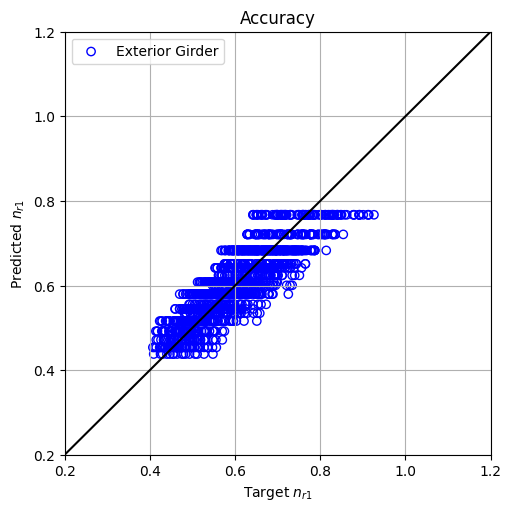

In [275]:
x_line = [0.2, 1.2]
y_line = [0.2, 1.2]

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), constrained_layout = True)

ax1.scatter(x=n_bm1, y=n_bm1_pred, marker='o', c='none', edgecolor='b', label='Exterior Girder')
ax1.plot(x_line, y_line, c = "k")
ax1.set_title('Accuracy')
ax1.legend()
plt.xlim((0.2,1.2))
plt.ylim((0.2,1.2))
ax1.set_xlabel('Target $n_{r1}$')
ax1.set_ylabel('Predicted $n_{r1}$')
ax1.grid()

In [262]:
model.latex(n)

'\\frac{x_{4} \\left(x_{2} + 1.47\\right)}{x_{0} \\frac{1}{x_{3} + 1.47}} + 0.272'

In [263]:
print(X[0])

[6.00000000e+01 1.00000000e+00 6.00000000e+00 1.54913677e-01
 1.16666667e+00 1.00000000e+04]
